In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

Ставим geohash2 для работы с географическими координатами:

In [149]:
!pip install geohash2

In [150]:
import geohash2 as gh

In [151]:
plt.rcParams['figure.figsize'] = (16, 8)
pd.set_option('display.max_rows', None)

In [152]:
df = pd.read_csv('AB_NYC_2019.csv', index_col=[0])

Убираем столбцы, соглазно ДЗ.

Добавляем колонку "price_category" для упрощения визуализации.

In [153]:
df.drop(['name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
df['price_category'] = pd.cut(df.price,[-1, 100, 200, 500, 1000, np.inf],labels=['0-100$', '100-200$', '200-500$', '500-1000$', 'более 1000$'], include_lowest=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_category
id,,,,,,,,,,,,
2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,100-200$
2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,200-500$
3647,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365,100-200$
3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,0-100$
5022,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,0-100$


In [154]:
df.shape

(48895, 12)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   neighbourhood_group             48895 non-null  object  
 1   neighbourhood                   48895 non-null  object  
 2   latitude                        48895 non-null  float64 
 3   longitude                       48895 non-null  float64 
 4   room_type                       48895 non-null  object  
 5   price                           48895 non-null  int64   
 6   minimum_nights                  48895 non-null  int64   
 7   number_of_reviews               48895 non-null  int64   
 8   reviews_per_month               38843 non-null  float64 
 9   calculated_host_listings_count  48895 non-null  int64   
 10  availability_365                48895 non-null  int64   
 11  price_category                  48895 non-null  category
dtypes: category(

In [156]:
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
price_category                        0
dtype: int64

Столбец "reviews_per_month" численного типа, отсутствие в нем значения можно заменить на 0

In [157]:
df.fillna({'reviews_per_month': 0}, inplace=True)

In [158]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
price_category                    0
dtype: int64

 Теперь пропусков данных в наборе нет.
 
 Анализ численных признаков:

In [159]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Анализ категориальных признаков:

In [160]:
boro_list = df.neighbourhood_group.unique()
print('Столбец категориальных данных "neighbourhood_group":')
print(', '.join(boro_list))
print(f'Количество уникальных значений: {len(boro_list)}')

Столбец категориальных данных "neighbourhood_group":
Brooklyn, Manhattan, Queens, Staten Island, Bronx
Количество уникальных значений: 5


In [161]:
nhood_list = df.neighbourhood.unique()
print('Столбец категориальных данных "neighbourhood":')
print(', '.join(nhood_list))
print(f'Количество уникальных значений: {len(nhood_list)}')

Столбец категориальных данных "neighbourhood":
Kensington, Midtown, Harlem, Clinton Hill, East Harlem, Murray Hill, Bedford-Stuyvesant, Hell's Kitchen, Upper West Side, Chinatown, South Slope, West Village, Williamsburg, Fort Greene, Chelsea, Crown Heights, Park Slope, Windsor Terrace, Inwood, East Village, Greenpoint, Bushwick, Flatbush, Lower East Side, Prospect-Lefferts Gardens, Long Island City, Kips Bay, SoHo, Upper East Side, Prospect Heights, Washington Heights, Woodside, Brooklyn Heights, Carroll Gardens, Gowanus, Flatlands, Cobble Hill, Flushing, Boerum Hill, Sunnyside, DUMBO, St. George, Highbridge, Financial District, Ridgewood, Morningside Heights, Jamaica, Middle Village, NoHo, Ditmars Steinway, Flatiron District, Roosevelt Island, Greenwich Village, Little Italy, East Flatbush, Tompkinsville, Astoria, Clason Point, Eastchester, Kingsbridge, Two Bridges, Queens Village, Rockaway Beach, Forest Hills, Nolita, Woodlawn, University Heights, Gravesend, Gramercy, Allerton, East 

In [162]:
roomtype_list = df.room_type.unique()
print('Столбец категориальных данных "room_type":')
print(', '.join(roomtype_list))
print(f'Количество уникальных значений: {len(roomtype_list)}')

Столбец категориальных данных "room_type":
Private room, Entire home/apt, Shared room
Количество уникальных значений: 3


Предварительный анализ набора данных: 48895 наблюдения и 11 признаков (после очистки от столбцов, предусмотренных ДЗ), из которых 8 - числовые и 3 - категориальные (не порядковые). Набор данных содержит сведения как о географическом (как в координатах, так и по принадлежности к району) положении жилья, сдаваемого в аренду через сервис "Airbnb", так и о типе жилья, стоимости аренды, количестве дней доступности в году, минимальном сроке аренды, количестве отзывов, средней количестве отзывов в месяц и количестве объявлений:
- neighbourhood_group - боро г. Нью-Йорк
- neighbourhood - район г. Нью-Йорк
- latitude - широта
- longitude - долгота
- room_type - тип жилья
- price - стоимость аренды
- minimum_nights - минимальное количество суток аренды
- number_of_reviews - количество отзывов
- reviews_per_month - количество отзывов в месяц
- calculated_host_listings_count - количество объявлений об аренде
- availability_365 - количество дней в году, в которые жилье доступно для аренды

Распределения категориальных переменных:

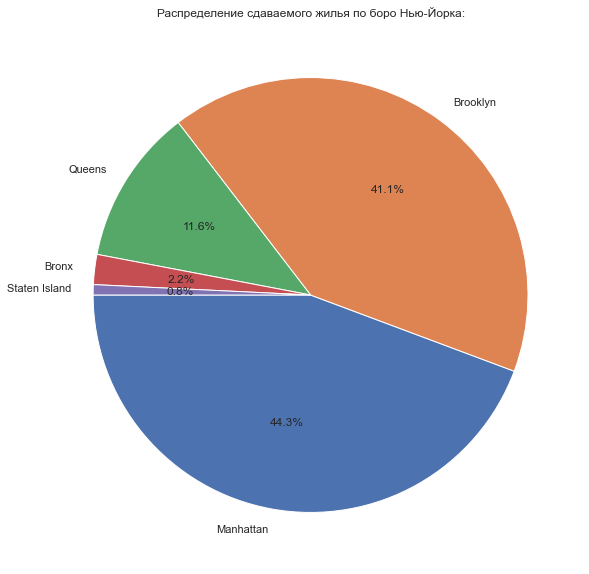

In [163]:
sns.set(rc={'figure.figsize':(10,10)})
plt.title("Распределение сдаваемого жилья по боро Нью-Йорка:")
plt.pie(df.neighbourhood_group.value_counts(), labels=df.neighbourhood_group.value_counts().index,autopct='%1.1f%%', startangle=180)
plt.show()

Распределение сдаваемого жилья по районам Нью-Йорка:

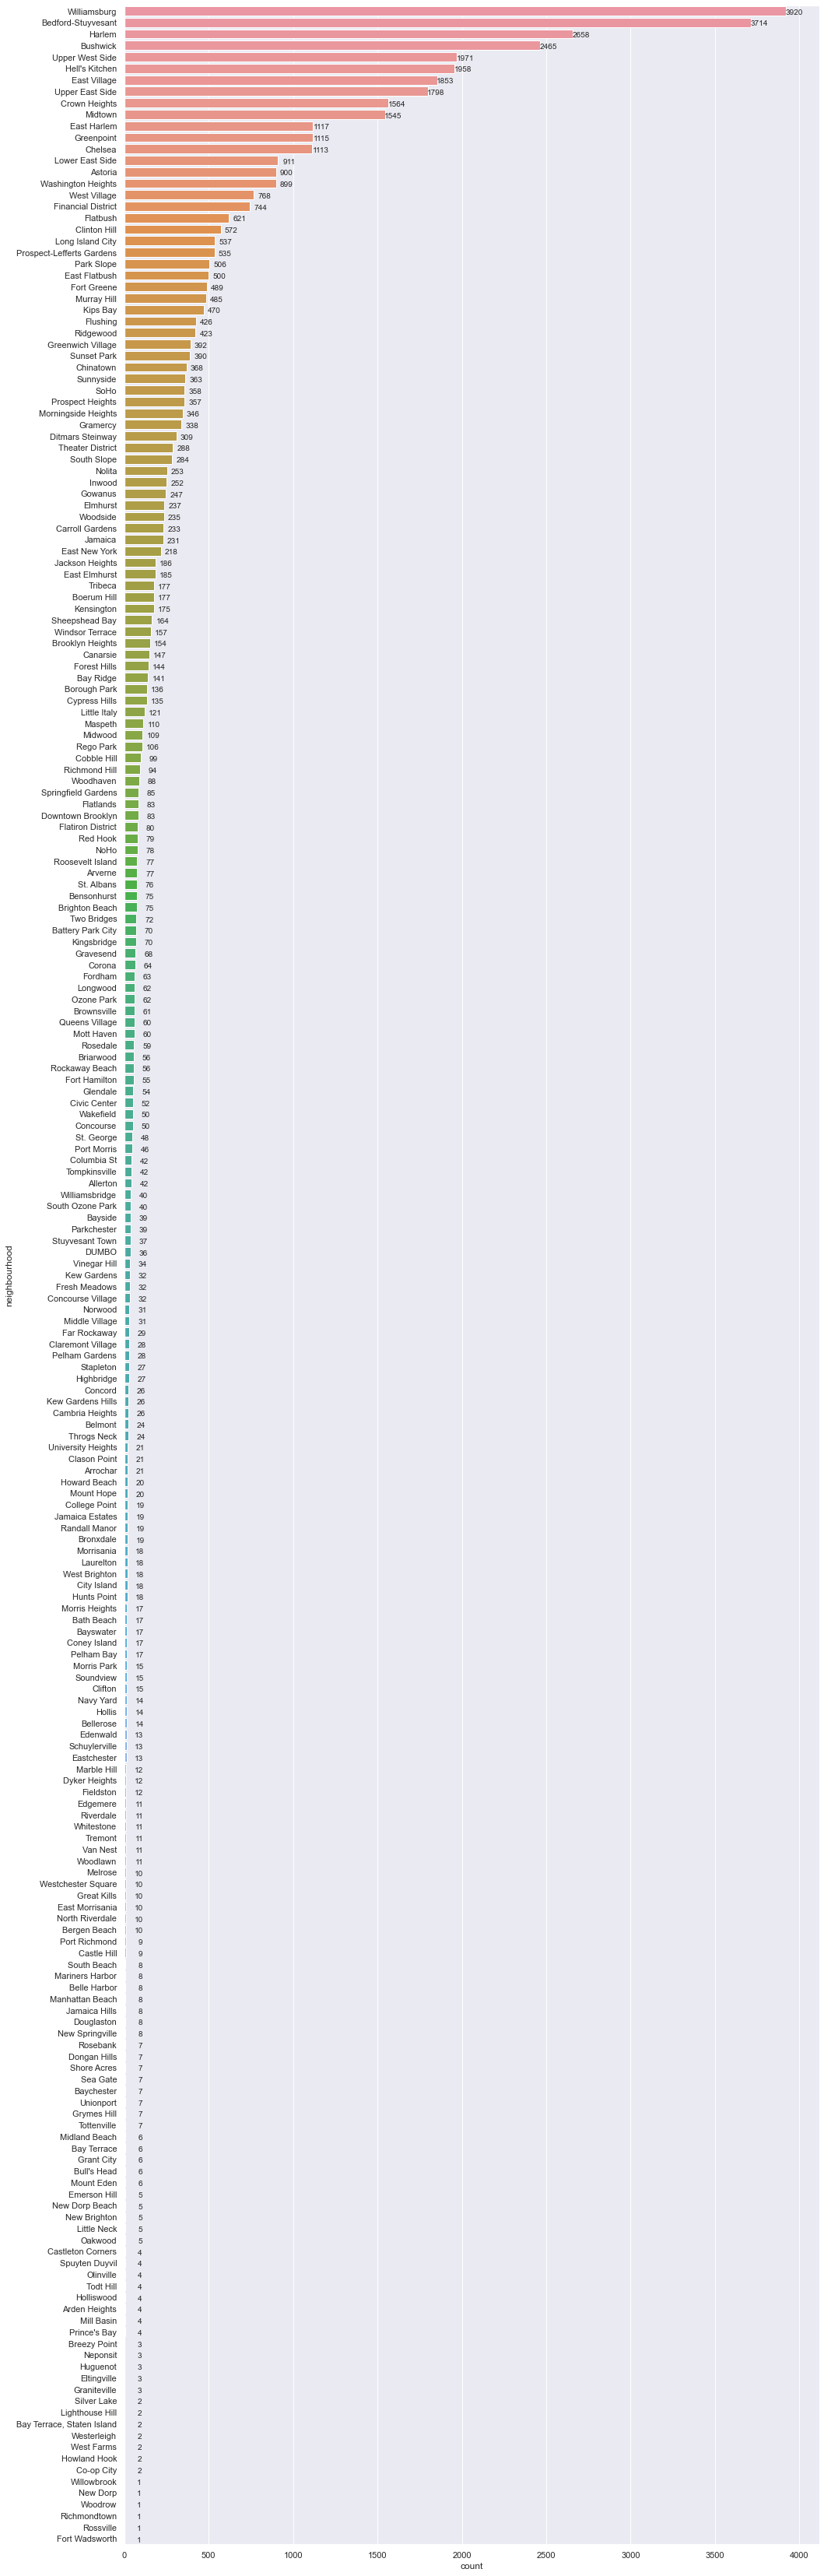

In [164]:
sns.set(rc={'figure.figsize':(16,60)})
ax = sns.countplot(y='neighbourhood', data = df, order = df['neighbourhood'].value_counts().index, orient='h')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(22, -10),fontsize=10, textcoords='offset points', horizontalalignment='right')
sns.set_style("whitegrid")
plt.show()

Распределение сдаваемого жилья по типам:

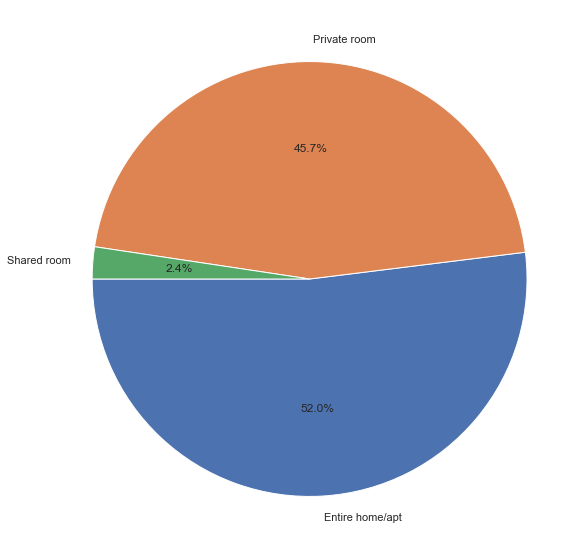

In [165]:
sns.set(rc={'figure.figsize':(10,10)})
plt.pie(df.room_type.value_counts(), labels=df.room_type.value_counts().index,autopct='%1.1f%%', startangle=180)
plt.show()

Распределение типа жилья по боро Нью-Йорка:

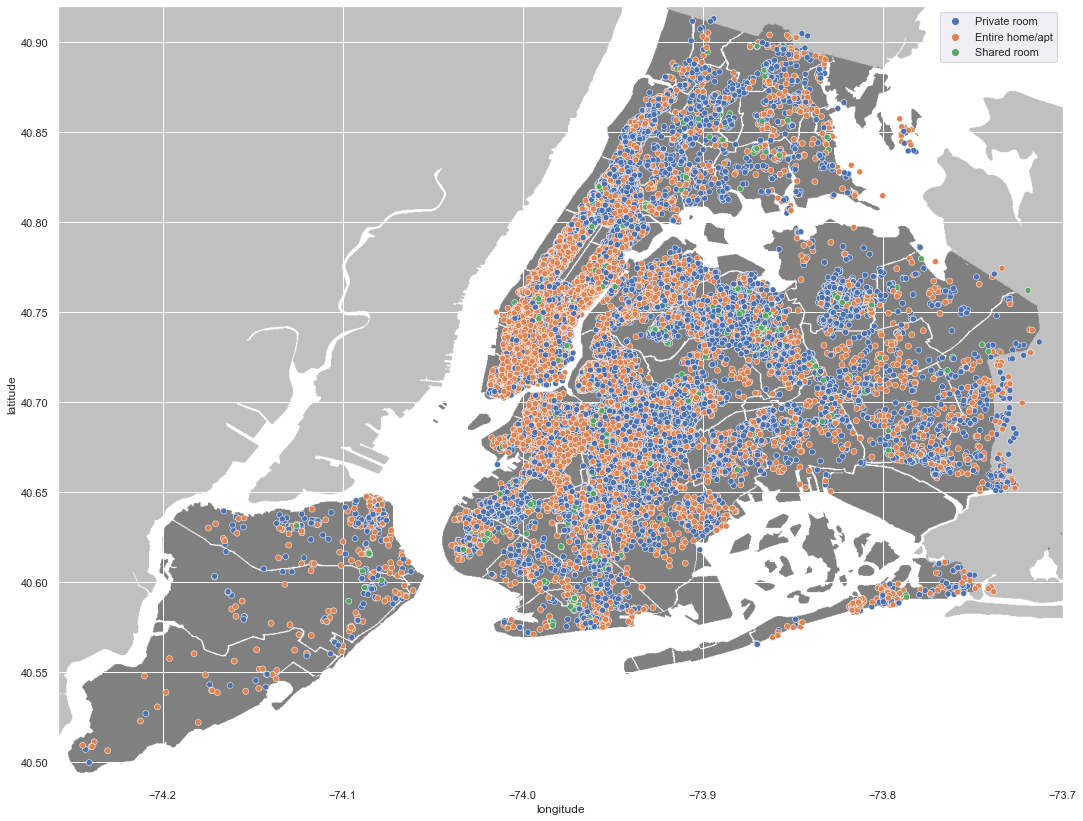

In [166]:
plt.figure(figsize=(18,16))
with open('New_York_City_.png', 'rb') as image_file:
    nyc_img = plt.imread(image_file)
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()
sns.scatterplot(x=df.longitude,y=df.latitude,hue=df.room_type);
plt.legend()
plt.show()

Распределение стоимости жилья по боро Нью-Йорка:

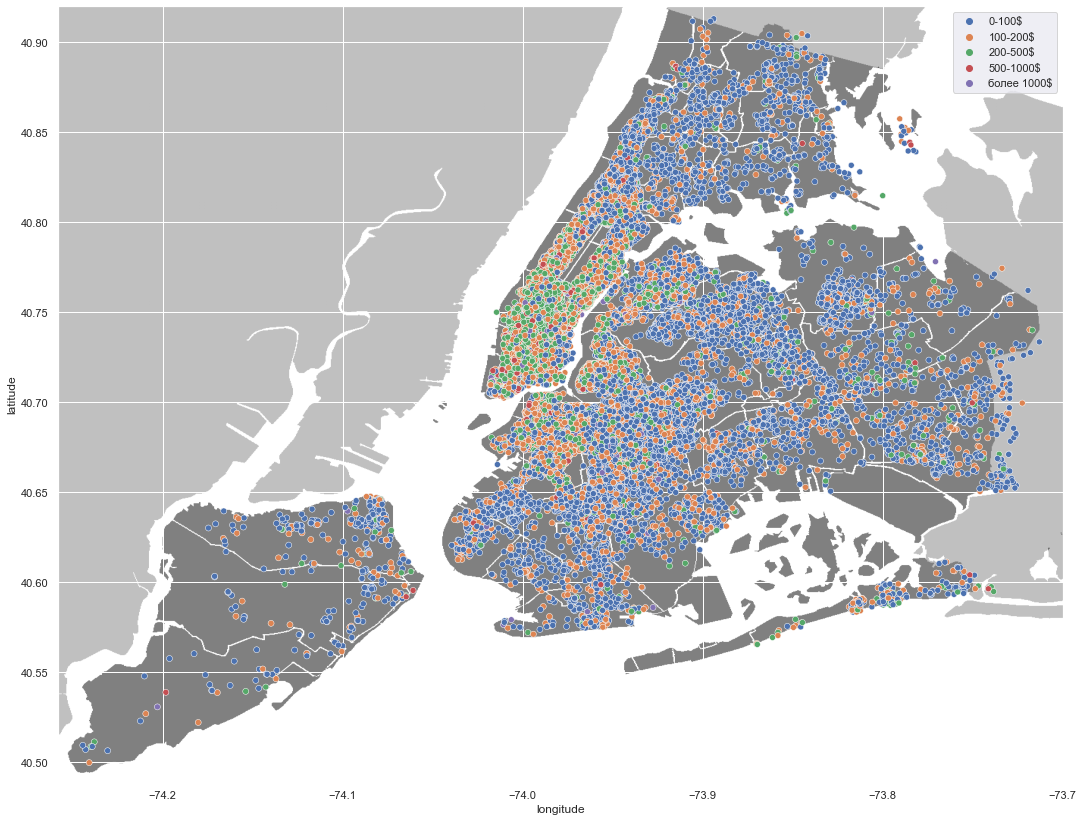

In [167]:
plt.figure(figsize=(18,16))
with open('New_York_City_.png', 'rb') as image_file:
    nyc_img = plt.imread(image_file)
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()
sns.scatterplot(x=df.longitude,y=df.latitude,hue=df.price_category);
plt.legend()
plt.show()

Распределение сдаваемого жилья по стоимости:

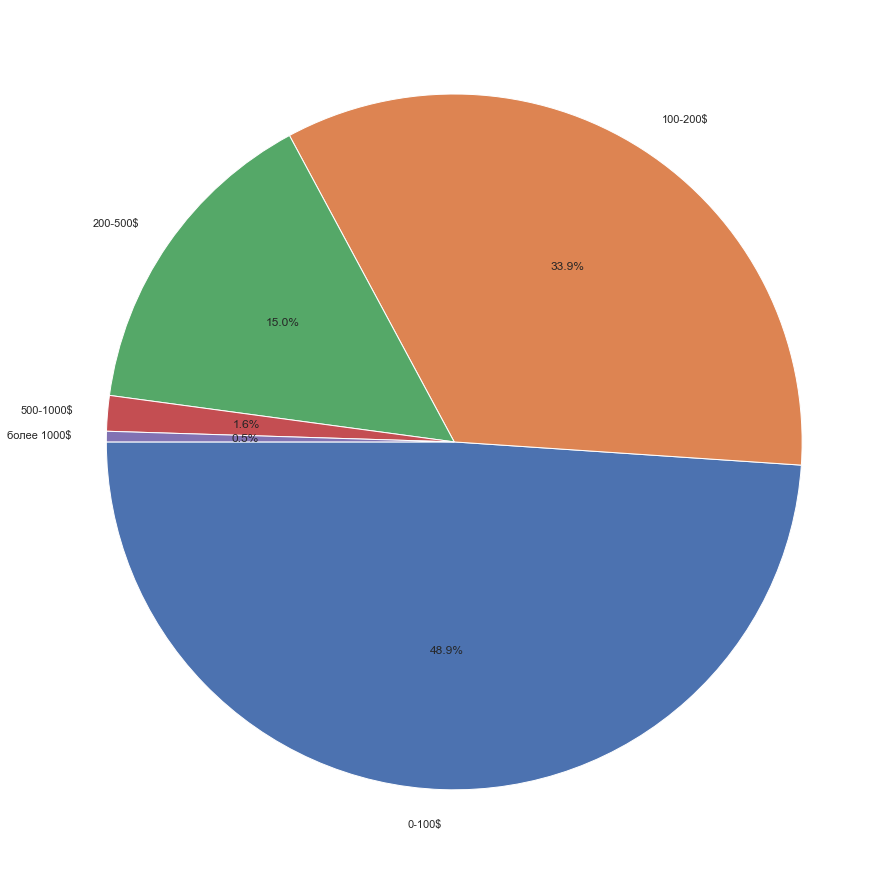

In [168]:
sns.set(rc={'figure.figsize':(16,16)})
plt.pie(df.price_category.value_counts(), labels=df.price_category.value_counts().index,autopct='%1.1f%%', startangle=180)
plt.show()

Распределение сдаваемого жилья по количеству отзывов:

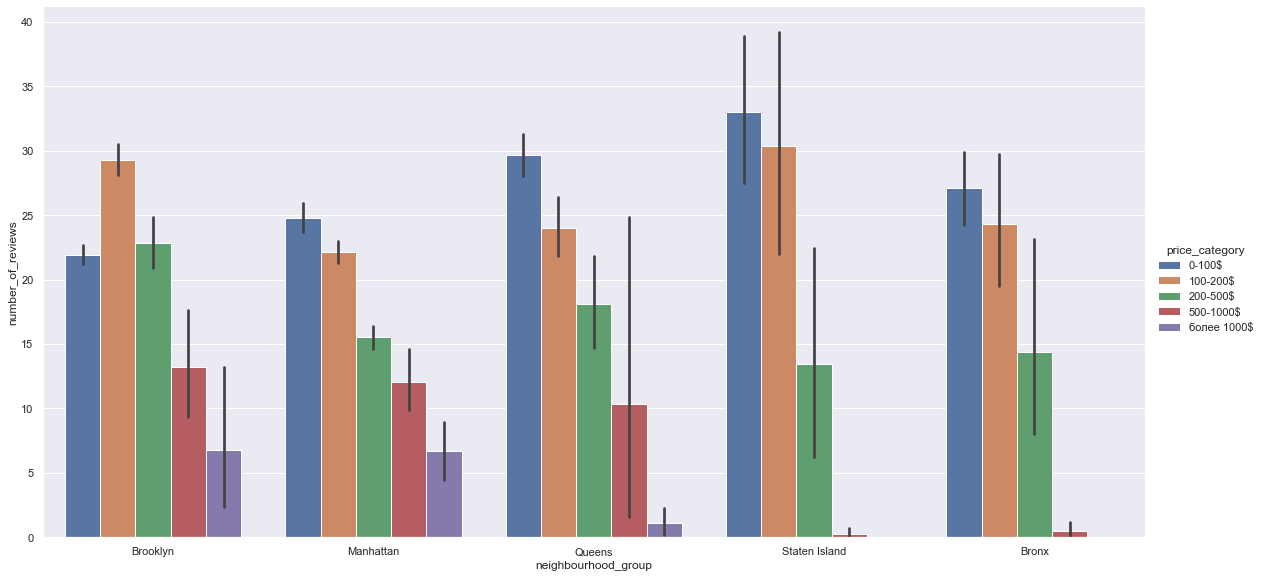

In [169]:
sns.catplot(data=df, kind='bar', x='neighbourhood_group', y='number_of_reviews', hue='price_category', orient='v', height=8, aspect=2);
plt.show()

Распределение сдаваемого жилья по количеству доступных дней аренды:

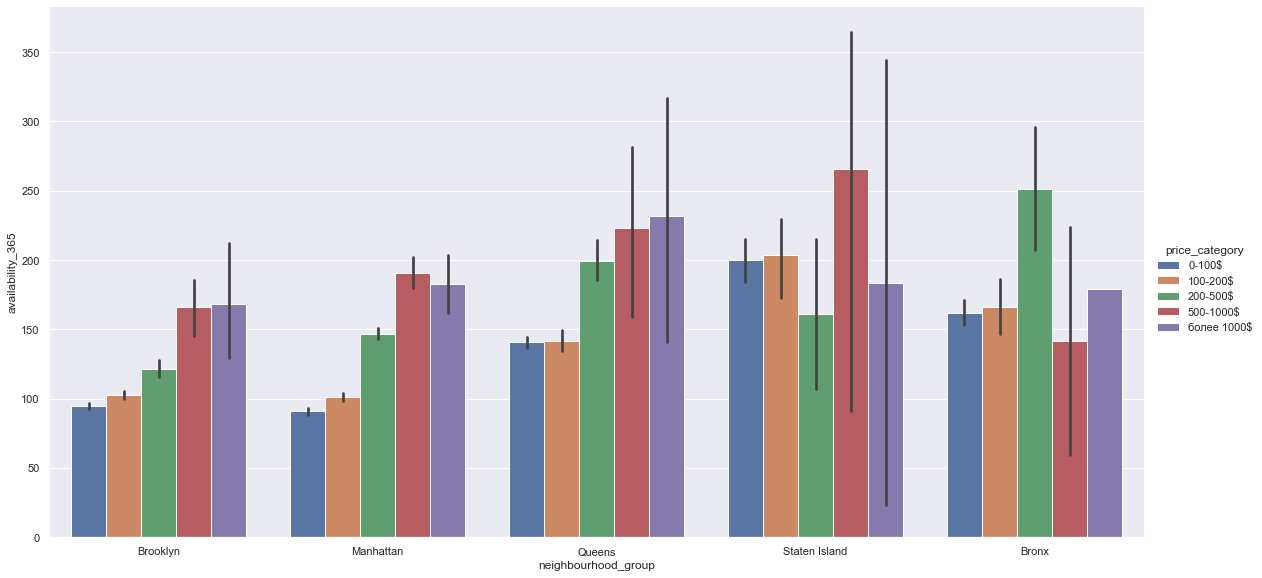

In [170]:
sns.catplot(data=df, kind='bar', x='neighbourhood_group', y='availability_365', hue='price_category', orient='v', height=8, aspect=2);
plt.show()

Распределение стоимости аренды по ценовым категориям:

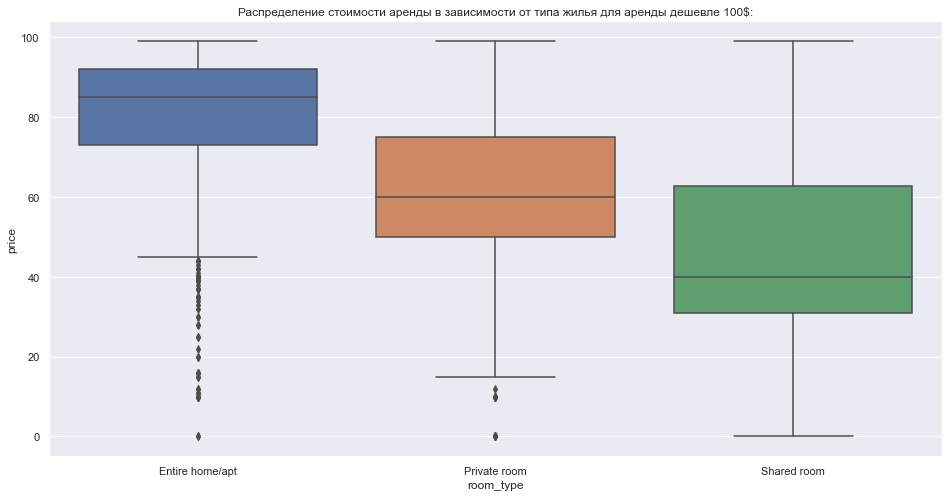

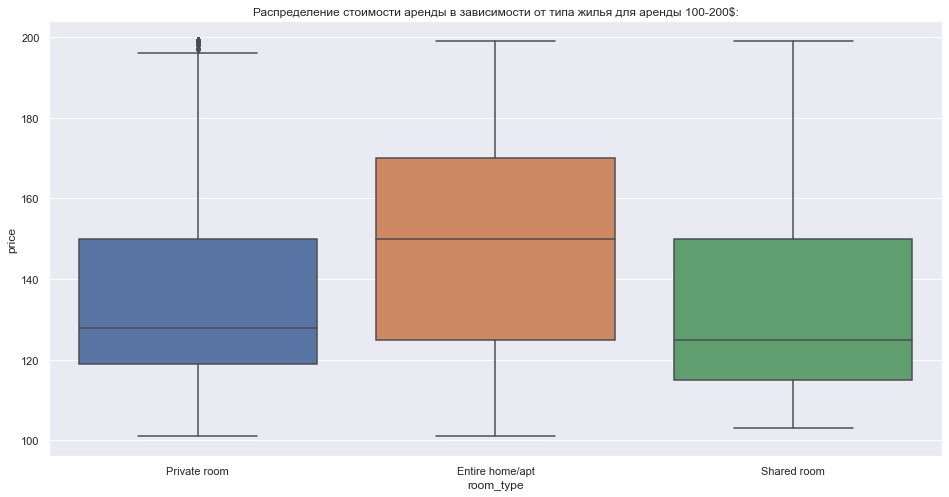

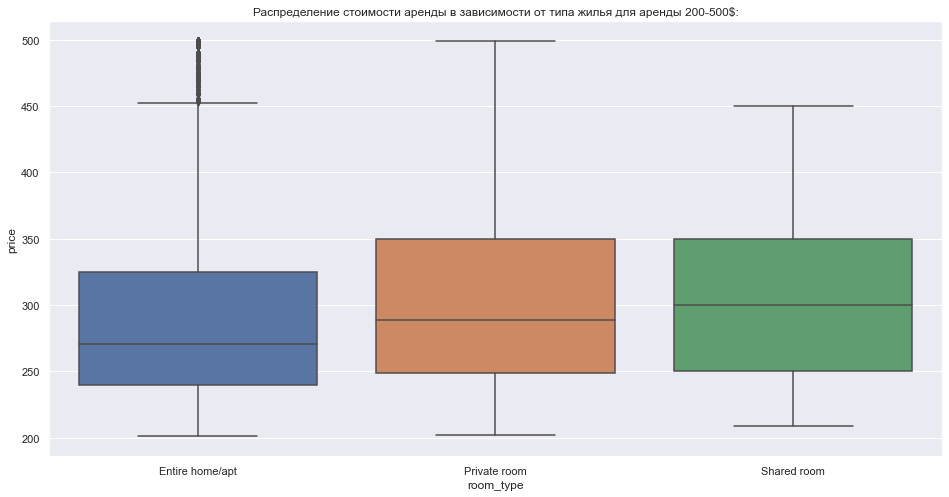

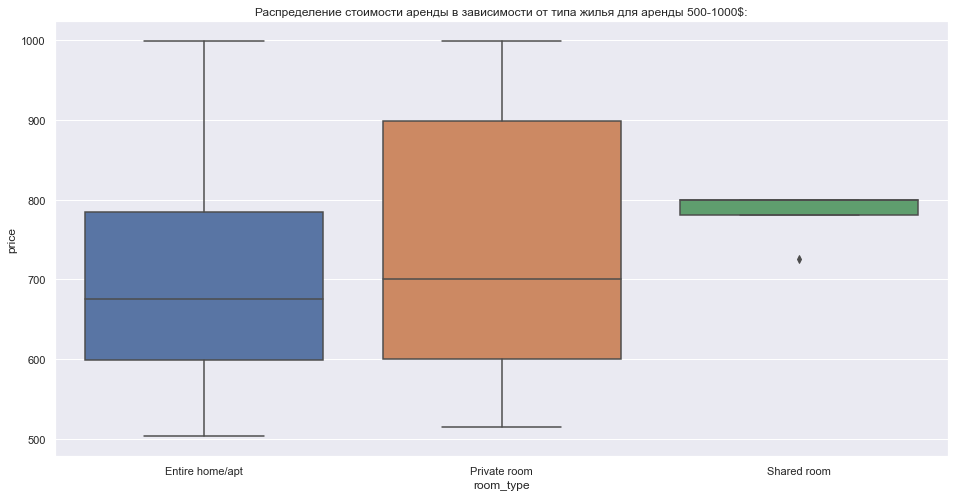

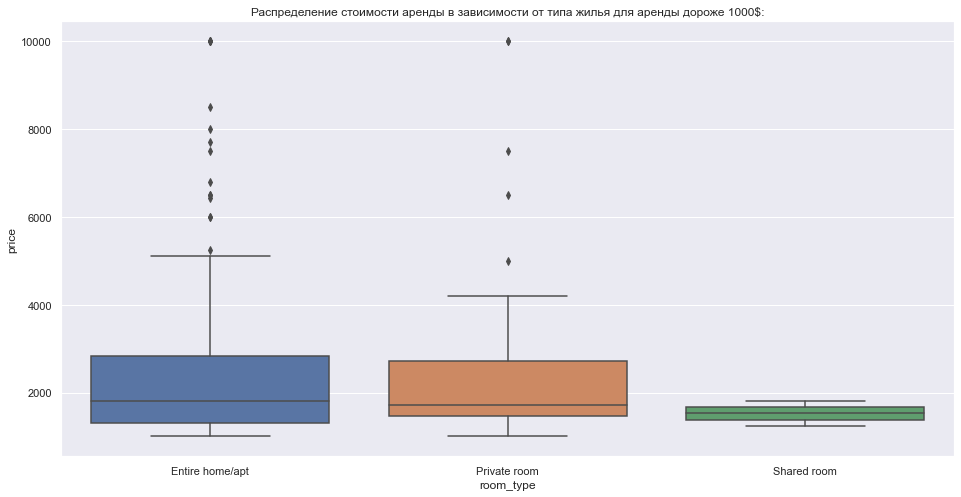

In [171]:
title = 'Распределение стоимости аренды в зависимости от типа жилья для аренды дешевле 100$:'
df_filtered = df.loc[df['price'] < 100]
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='room_type', y='price', data=df_filtered)
plt.title(title)
plt.ioff()

title = 'Распределение стоимости аренды в зависимости от типа жилья для аренды 100-200$:'
df_filtered = df.loc[(df['price'] > 100) & (df['price'] < 200)]
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='room_type', y='price', data=df_filtered)
plt.title(title)
plt.ioff()

title = 'Распределение стоимости аренды в зависимости от типа жилья для аренды 200-500$:'
df_filtered = df.loc[(df['price'] > 200) & (df['price'] < 500)]
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='room_type', y='price', data=df_filtered)
plt.title(title)
plt.ioff()

title = 'Распределение стоимости аренды в зависимости от типа жилья для аренды 500-1000$:'
df_filtered = df.loc[(df['price'] > 500) & (df['price'] < 1000)]
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='room_type', y='price', data=df_filtered)
plt.title(title)
plt.ioff()

title = 'Распределение стоимости аренды в зависимости от типа жилья для аренды дороже 1000$:'
df_filtered = df.loc[df['price'] > 1000]
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='room_type', y='price', data=df_filtered)
plt.title(title)
plt.ioff()

In [172]:
print('Средняя стоиомость аренды по типу жилья и боро:')
df.pivot_table(index='neighbourhood_group',columns='room_type',values='price',aggfunc='mean')

Средняя стоиомость аренды по типу жилья и боро:


room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Bronx,127.506596,66.788344,59.800000
Brooklyn,178.327545,76.500099,50.527845
Manhattan,249.239109,116.776622,88.977083
Queens,147.050573,71.762456,69.020202
Staten Island,173.846591,62.292553,57.444444


Тепловая карта числовых признаков набора данных:

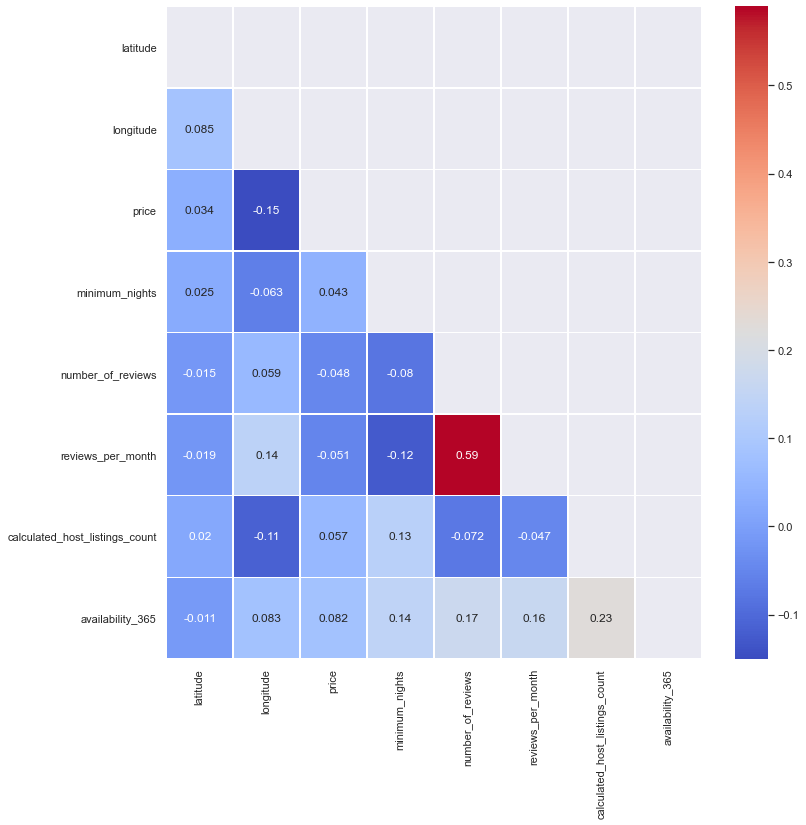

In [173]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, mask=np.triu(df.corr()), cmap='coolwarm', linewidths=.5, ax=ax)
plt.show()

Из тепловой карты видно, что текущие признаки очень слабо коррелированы с целевой переменной (стоимость, признак "price").

Убираем вспомогательный столбец "price_category":

In [174]:
df.drop('price_category', axis=1, inplace=True)

Функция для подготовки, разделения и нормализации набора данных для обучения модели:

In [175]:
def dataset_prepare(dataset):
    categorical_features = dataset.select_dtypes(include=['object'])
    categorical_features_processed = pd.get_dummies(categorical_features)
    numerical_features =  dataset.select_dtypes(exclude=['object'])
    combined_df = pd.concat([numerical_features, categorical_features_processed], axis=1)
    x = combined_df.drop(['price'], axis=1)
    y = combined_df['price']
    scaler = StandardScaler() ##  RobustScaler
    scaler = scaler.fit(x)
    x_normalized = scaler.transform(x)
    return train_test_split(x_normalized, y, test_size=0.3, random_state=1)

Функция для оценки параметров качества модели:

In [176]:
def model_scorer(model, xtr, ytr, xtst, ytst):
    model.fit(xtr, ytr)
    predict = model.predict(xtst)
    mae = metrics.mean_absolute_error(ytst, predict)
    mse = metrics.mean_squared_error(ytst, predict)
    rmse = np.sqrt(metrics.mean_squared_error(ytst, predict))
    r2 = metrics.r2_score(ytst, predict)

    print(f'   MAE: {mae}')
    print(f'   MSE: {mse}')
    print(f'   RMSE: {rmse}')
    print(f'   R2: {r2}')
    print(f' ')

Работа с базовыми моделями LinearRegression, RidgeCV, LassoCV, ElasticNetCV, оценка их качества:

In [177]:
x_train, x_test, y_train, y_test = dataset_prepare(df)

print('Метрики LinearRegression:')
lin_reg = LinearRegression()
model_scorer(lin_reg, x_train, y_train, x_test, y_test)

print('Метрики RidgeCV:')
ridge = RidgeCV()
model_scorer(ridge, x_train, y_train, x_test, y_test)

print('Метрики LassoCV:')
lasso = LassoCV()
model_scorer(lasso, x_train, y_train, x_test, y_test)

print('Метрики ElasticNetCV:')
elastic = ElasticNetCV()
model_scorer(lin_reg, x_train, y_train, x_test, y_test)

Метрики LinearRegression:
   MAE: 30375573031784.074
   MSE: 4.582758513719073e+30
   RMSE: 2140737843295874.8
   R2: -7.769832018420813e+25
 
Метрики RidgeCV:
   MAE: 72.28509676540156
   MSE: 53185.85092769805
   RMSE: 230.62057784963173
   R2: 0.09826117560442582
 
Метрики LassoCV:
   MAE: 71.5719513212217
   MSE: 53187.277321525275
   RMSE: 230.6236703409372
   R2: 0.09823699182865753
 
Метрики ElasticNetCV:
   MAE: 30375573031784.074
   MSE: 4.582758513719073e+30
   RMSE: 2140737843295874.8
   R2: -7.769832018420813e+25
 


Пробуем в feature engineering )) загружаем заново набор, удаляем ненужные столбцы. 
- Объединяем признаки "number_of_reviews" и "reviews_per_month" в признак "month_total"
- Вводим временный признак "price_category" - ценовая категория и с помощью широты и долготы ("latitude", "longitude") проводим кластеризацию на 5 кластеров в признак "custom_price_category"
- Чтобы убрать признак "neighbourhood" с широким диапазоном (221 значение для one-hot кодирования) - заменяем его при помощи широты и долготы ("latitude", "longitude") в geohash признак "geohash" с точностью ±2.4 км (получится по сути категориальный признак, зато диапазон значений уменьшится, измерять расстояние от жилья до какого-то объекта считаю нецелесообразным т.к. непонятен критерий выбора объекта - парк, станция метро и т.д. это очень субъективный параметр, кто-то хочет вид на озеро, а кто-то меньше идти до станции) 
- Кластеризуем признаки "minimum_nights" и "availability_365" в 5 кластеров. 

Выбор количества кластеров связан с разбивкой ценовой категории на 5 классов, оценка его оптимального количества не проводилась.

In [178]:
df_opt = pd.read_csv('AB_NYC_2019.csv', index_col=[0])
df_opt.drop(['name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
df_opt.fillna({'reviews_per_month': 0}, inplace=True)
df_opt['month_total'] = df_opt['number_of_reviews'] / df_opt['reviews_per_month']
df_opt.fillna({'month_total': 0}, inplace=True)
df_opt['geohash']=df_opt.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=5), axis=1)
df_opt['price_category'] = pd.cut(df.price,[-1, 100, 200, 500, 1000, np.inf],labels=['0-100', '100-200', '200-500', '500-1000', '>1000'], include_lowest=True)
prc = {'200-500': 3, '500-1000': 4, '0-100': 1, '>1000': 5,  '100-200': 2}
df_opt['price_rating'] = df_opt['price_category'].map(prc)
df_opt['price_rating'] = df_opt['price_rating'].astype('int64')

features=['minimum_nights', 'availability_365']
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_opt[features])
df_opt['custom_nights'] = kmeans.predict(df_opt[features])

features=['latitude', 'longitude', 'price_rating']
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_opt[features])
df_opt['custom_price_category'] = kmeans.predict(df_opt[features])

df_opt.drop(['latitude', 'longitude', 'neighbourhood', 'number_of_reviews', 'reviews_per_month', 'price_category', 'price_rating', 'minimum_nights', 'availability_365'], axis=1, inplace=True)


In [179]:
df_opt.head()

,neighbourhood_group,room_type,price,calculated_host_listings_count,month_total,geohash,custom_nights,custom_price_category
id,,,,,,,,
2539,Brooklyn,Private room,149,6,42.857143,dr5rh,1,1
2595,Manhattan,Entire home/apt,225,2,118.421053,dr5ru,1,2
3647,Manhattan,Private room,150,1,0.000000,dr72j,1,1
3831,Brooklyn,Entire home/apt,89,1,58.189655,dr5rm,4,0
5022,Manhattan,Entire home/apt,80,1,90.000000,dr72j,0,0


Работа с базовыми моделями LinearRegression, RidgeCV, LassoCV, ElasticNetCV, оценка их качества после манипуляций с данными:

In [180]:
x_train, x_test, y_train, y_test = dataset_prepare(df_opt)

print('Метрики LinearRegression:')
lin_reg = LinearRegression()
model_scorer(lin_reg, x_train, y_train, x_test, y_test)

print('Метрики RidgeCV:')
ridge = RidgeCV()
model_scorer(ridge, x_train, y_train, x_test, y_test)

print('Метрики LassoCV:')
lasso = LassoCV()
model_scorer(lasso, x_train, y_train, x_test, y_test)

print('Метрики ElasticNetCV:')
elastic = ElasticNetCV()
model_scorer(lin_reg, x_train, y_train, x_test, y_test)

Метрики LinearRegression:
   MAE: 54.56027278235946
   MSE: 41003.65429077003
   RMSE: 202.4935907399788
   R2: 0.3048040715500533
 
Метрики RidgeCV:
   MAE: 54.498568671315894
   MSE: 41004.65172233245
   RMSE: 202.4960535969342
   R2: 0.30478716060947764
 
Метрики LassoCV:
   MAE: 53.659009300244215
   MSE: 41013.44828284177
   RMSE: 202.51777275795268
   R2: 0.30463801943764246
 
Метрики ElasticNetCV:
   MAE: 54.56027278235946
   MSE: 41003.65429077003
   RMSE: 202.4935907399788
   R2: 0.3048040715500533
 


Можно наблюдать, что при удалении признака "neighbourhood" - район, а точнее его замене на geohash - модели LinearRegression и ElasticNetCV стали лучше прилегать к данным, что видно по более адекватным значениям метрик, которые мы снимаем. Также метрики улучшились и для остальных моделей.

Попробуем отобрать наилучшие признаки и построить модель с их оптимальным количеством:

In [181]:
def select_features(X_train, y_train, X_test):
    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
    grid = dict()
    grid['sel__k'] = [i for i in range(2, X_train.shape[1]+1)]
    search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
    results = search.fit(X_train, y_train)
    print(f'Лучшая MAE: {results.best_score_}')
    print(f'Получена при количестве признаков: {results.best_params_}')
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    fs = SelectKBest(score_func=mutual_info_regression, k=results.best_params_['sel__k'])
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    categorical_features = df_opt.select_dtypes(include=['object'])
    categorical_features_processed = pd.get_dummies(categorical_features)
    numerical_features =  df_opt.select_dtypes(exclude=['object'])
    combined_df = pd.concat([numerical_features, categorical_features_processed], axis=1)
    combined_df.drop(['price'], axis=1, inplace=True)
    
    print('\nЛучшие признаки для модели:')
    for feature in combined_df.columns[fs.get_support(indices=True)].tolist():
        print(feature)
    print('\n')
    return X_train_fs, X_test_fs, fs

Также настраиваем гиперпараметры моделей, используя встроенные возможности кросс-валидации:

In [182]:
X_train_fs, X_test_fs, fs = select_features(x_train, y_train, x_test)

print('Метрики LinearRegression:')
lin_reg = LinearRegression()
model_scorer(lin_reg, X_train_fs, y_train, X_test_fs, y_test)

print('Метрики RidgeCV:')
ridge = RidgeCV(alphas=[0.001,0.01,1,10])
model_scorer(ridge, X_train_fs, y_train, X_test_fs, y_test)

print('Метрики LassoCV:')
alphavec = 10**np.linspace(-2,2,200)
lasso = LassoCV(alphas = alphavec, cv=5)
model_scorer(lasso, X_train_fs, y_train, X_test_fs, y_test)

print('Метрики ElasticNetCV:')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
elastic = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
model_scorer(lin_reg, X_train_fs, y_train, X_test_fs, y_test)

Лучшая MAE: -38880.50069572643
Получена при количестве признаков: {'sel__k': 16}

Лучшие признаки для модели:
calculated_host_listings_count
month_total
custom_nights
custom_price_category
neighbourhood_group_Brooklyn
neighbourhood_group_Manhattan
neighbourhood_group_Queens
room_type_Entire home/apt
room_type_Private room
room_type_Shared room
geohash_dr5re
geohash_dr5rm
geohash_dr5rq
geohash_dr5rs
geohash_dr5rt
geohash_dr5ru


Метрики LinearRegression:
   MAE: 54.32106691017425
   MSE: 41001.470319202905
   RMSE: 202.48819797509904
   R2: 0.30484109966785344
 
Метрики RidgeCV:
   MAE: 54.31508538125312
   MSE: 41001.460330527116
   RMSE: 202.48817331026302
   R2: 0.3048412690207284
 
Метрики LassoCV:
   MAE: 54.076035224192324
   MSE: 41000.087173540865
   RMSE: 202.48478257276733
   R2: 0.3048645501931624
 
Метрики ElasticNetCV:
   MAE: 54.32106691017425
   MSE: 41001.470319202905
   RMSE: 202.48819797509904
   R2: 0.30484109966785344
 


Итого: в ходе работы была изучена возможность улучшения качества моделей при помощи различных манипуляций с признаками: уменьшением их количества, уменьшением их диапазона, нормализацией, отбором их оптимального количества. Настройка гиперпараметров практически не улучшила характеристики модели, то есть выбор оптимальных признаков моедли более приоритетно, чем тюнинг гиперпараметров.